# Neural Network

In [4]:
import numpy as np
import tensorflow as tf
import keras
import cv2
import os
import matplotlib.pyplot as plt
import nnfunctions
from sklearn.model_selection import train_test_split


In [5]:
# RUN THIS CELL TO LOAD DATA AND SORT INTO SAMPLES AND LABELS

# CHANGE PATH TO ROOT DIRECTORY OF WHERE YOUR DATA IS LOCATED
# e.g. ./projects/
dataloc = './'

# don't change this
datadir = dataloc + 'ADE20K_2017_05_30_consistency/images/consistencyanalysis/original_ade20k/'
imgkeys = [im.split('_seg')[0] for im in os.listdir(datadir) if '_seg' in im]
lblpaths = [datadir+im for im in os.listdir(datadir) if '_seg' in im]
imgpaths = [datadir+im for im in os.listdir(datadir) if '.jpg' in im and im.split('.jpg')[0] in imgkeys]


imgpaths.sort()
lblpaths.sort()
print('Total # of images =', len(imgpaths))
print('Total # of labels =', len(lblpaths))
imgpaths[:5], lblpaths[:5]

Total # of images = 64
Total # of labels = 64


(['./ADE20K_2017_05_30_consistency/images/consistencyanalysis/original_ade20k/ADE_val_00001001.jpg',
  './ADE20K_2017_05_30_consistency/images/consistencyanalysis/original_ade20k/ADE_val_00001005.jpg',
  './ADE20K_2017_05_30_consistency/images/consistencyanalysis/original_ade20k/ADE_val_00001015.jpg',
  './ADE20K_2017_05_30_consistency/images/consistencyanalysis/original_ade20k/ADE_val_00001034.jpg',
  './ADE20K_2017_05_30_consistency/images/consistencyanalysis/original_ade20k/ADE_val_00001054.jpg'],
 ['./ADE20K_2017_05_30_consistency/images/consistencyanalysis/original_ade20k/ADE_val_00001001_seg.png',
  './ADE20K_2017_05_30_consistency/images/consistencyanalysis/original_ade20k/ADE_val_00001005_seg.png',
  './ADE20K_2017_05_30_consistency/images/consistencyanalysis/original_ade20k/ADE_val_00001015_seg.png',
  './ADE20K_2017_05_30_consistency/images/consistencyanalysis/original_ade20k/ADE_val_00001034_seg.png',
  './ADE20K_2017_05_30_consistency/images/consistencyanalysis/original_ade

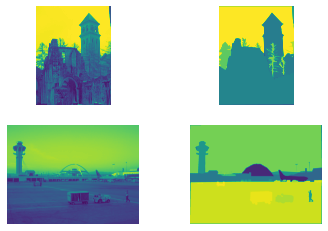

In [6]:
# VIEW SAMPLES
num_imgs_visualize =2
fig, ax = plt.subplots(num_imgs_visualize,2)
for i in range(num_imgs_visualize):
    img = cv2.imread(imgpaths[i], cv2.IMREAD_GRAYSCALE)
    lbl = cv2.imread(lblpaths[i], cv2.IMREAD_GRAYSCALE) 
    ax[i][0].imshow(img)
    ax[i][0].axis('off')
    ax[i][1].imshow(lbl)
    ax[i][1].axis('off')
plt.show()

In [7]:
def load_images(flatten_imgs=False):
    if flatten_imgs:
        X = np.array([cv2.imread(imgpath).flatten() for imgpath in imgpaths])
        Y = np.array([cv2.imread(lblpath).flatten() for lblpath in lblpaths])
    else:
        X = np.array([cv2.imread(imgpath) for imgpath in imgpaths])
        Y = np.array([cv2.imread(lblpath) for lblpath in lblpaths])
    return X,Y

In [8]:
%%time
# change flatten_imgs to True or False depending on how you want to load the data
flatten_imgs = False
X, Y = load_images(flatten_imgs)
print(X.shape, X[0], X[0].shape)

C:\Users\Kevin Rao\.conda\envs\proglearn\lib\site-packages\ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


(64,) [[[251 251 251]
  [251 251 251]
  [251 251 251]
  ...
  [ 48  69 100]
  [ 48  72 100]
  [ 46  73  99]]

 [[251 251 251]
  [251 251 251]
  [251 251 251]
  ...
  [ 49  70 101]
  [ 44  68  96]
  [ 42  69  95]]

 [[251 251 251]
  [251 251 251]
  [251 251 251]
  ...
  [ 47  71 101]
  [ 44  71  98]
  [ 44  71  98]]

 ...

 [[ 35  34  30]
  [ 35  34  30]
  [ 32  33  31]
  ...
  [210 213 188]
  [204 202 192]
  [202 197 194]]

 [[ 34  33  29]
  [ 34  33  29]
  [ 32  33  31]
  ...
  [185 179 160]
  [179 167 165]
  [178 164 168]]

 [[ 36  35  31]
  [ 36  35  31]
  [ 34  35  33]
  ...
  [118 110  93]
  [119 105 106]
  [119 102 111]]] (2200, 1650, 3)
Wall time: 1.62 s


C:\Users\Kevin Rao\.conda\envs\proglearn\lib\site-packages\ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys


In [18]:
def load_image(image, mask):
  input_image = tf.image.resize(image, (128, 128), method='nearest')
  input_mask = tf.image.resize(mask, (128, 128), method='nearest')


  return input_image, input_mask

In [19]:
X_data = np.zeros((X.shape[0], 128, 128, 3))
Y_data = np.zeros((Y.shape[0], 128, 128, 3))
for i, (x, y) in enumerate(zip(X, Y)):
    X_data[i], Y_data[i] = tf.cast(load_image(x,y), tf.int32)

Original Image # Unique Colors: 11
Resized Image # Unique Colors: 11


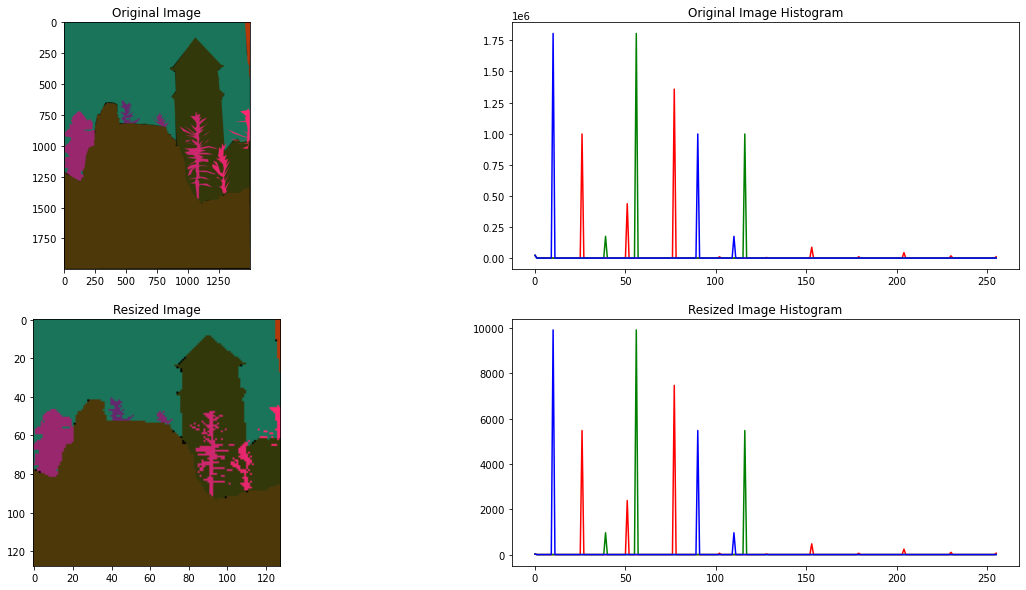

In [20]:
colors = ("red", "green", "blue")
channel_ids = (0, 1, 2)
for i in range(1):
    plt.figure(figsize=(20,10))
    plt.subplot(2,2,1)
    plt.imshow(Y[i])
    plt.title("Original Image")
    plt.subplot(2,2,2)
    for channel_id, c in zip(channel_ids, colors):
        histogram, bin_edges = np.histogram(
            Y[i][:, :, channel_id], bins=256, range=(0, 256)
        )
        plt.plot(bin_edges[0:-1], histogram, color=c)
    plt.title("Original Image Histogram")
    print("Original Image # Unique Colors:", len(np.unique(Y[i].reshape(-1, 3), axis=0)))
    plt.subplot(2,2,3)
    plt.imshow(tf.cast(Y_data[i],tf.int32))
    plt.title("Resized Image")
    plt.subplot(2,2,4)
    for channel_id, c in zip(channel_ids, colors):
        histogram, bin_edges = np.histogram(
            Y_data[i][:, :, channel_id], bins=256, range=(0, 256)
        )
        plt.plot(bin_edges[0:-1], histogram, color=c)
    plt.title("Resized Image Histogram")
    print("Resized Image # Unique Colors:", len(np.unique(Y_data[i].reshape(-1,3),axis=0)))

In [21]:
# hyperparameters

n_tasks = 10
n_batches = 3
n_classes = len(np.unique(Y_data.reshape(-1, 3)))

print(X_data[0].shape)
print(n_classes)

(128, 128, 3)
252


In [13]:
model = nnfunctions.unet(input = keras.Input(shape = X_data[0].shape), num_classes = n_classes)

In [14]:
model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [15]:
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size = 16)

In [16]:
print(model.input_shape)
print(model.output_shape)
print(model.summary())

(None, 128, 128, 1)
(None, 128, 128, 197)
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 128, 128, 64) 640         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 128, 128, 64) 36928       conv2d_20[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)  (None, 64, 64, 64)   0           conv2d_21[0][0]                  
__________________________________________________

In [17]:
model_history = model.fit(x = X_train, y = Y_train, epochs=4, verbose=1)

Epoch 1/4


In [ ]:
model.save("nn")

In [ ]:
predictions = model.predict(X_test)

accuracy = np.sum(predictions == Y_test) / len(Y_test)
print(accuracy)

In [ ]:
for i, Y_pred in enumerate(predictions):
    plt.figure()
    plt.subplots(1, 3, 1)
    plt.imshow(X_test[i])
    plt.title("Image")
    plt.subplots(1,3,2)
    plt.imshow(Y_test[i])
    plt.title("Segmentation Mask")
    plt.subplot(1,3,3)
    plt.imshow(Y_pred)
    plt.title("Predicted Mask")

In [ ]:
plt.figure()
plt.plot(model_history.epoch, model_history.history['loss'], label='Training loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Proglearn

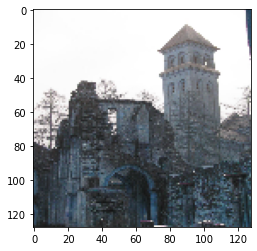

In [ ]:
fte = []
bte = []
te = []
accuracies = []

for which_task in range(1, n_tasks+1):

    def run_parallel_exp(shift):

        df_list = run_fte_bte_exp(data_x, data_y, which_task, model, shift=shift)

        return df_list

    shifts = np.arange(0, n_batches, 1)  # Number of test set batches
    acc = []

    for shift in shifts:
        acc.append(run_parallel_exp(shift))

    # Average forward transfer accuracies accross all permutations of testing and training batches for each task
    acc_x = []
    acc_y = []
    acc_z = []
    for z in range(which_task):
        for y in range(1):
            for x in range(n_batches):
                if model == "odin":
                    acc_x.append(acc[x][y]["task_accuracy"][z])
                elif model == "odif":
                    acc_x.append(acc[0][x][y]["task_accuracy"][z])
            acc_y.append(np.mean(acc_x))
            acc_x = []
        acc_z.append(np.mean(acc_y))
        acc_y = []

    # Calculate and store FTE
    fte.append((1 - acc_z[0]) / (1 - acc_z[-1]))

    # Average backward transfer accuracies accross all permutations of testing and training batches for each task
    acc_x = []
    acc_y = []
    acc_z = []
    for z in range((which_task - 1), n_tasks):
        for y in range(1):
            for x in range(n_batches):
                if model == "odin":
                    acc_x.append(acc[x][y]["task_accuracy"][z])
                elif model == "odif":
                    acc_x.append(acc[0][x][y]["task_accuracy"][z])
            acc_y.append(np.mean(acc_x))
            acc_x = []
        acc_z.append(np.mean(acc_y))
        acc_y = []

    # Calculate and store accuracies, BTE, and TE
    accuracies.append(acc_z)
    calc_bte = (1 - acc_z[0]) / ([1 - a for a in acc_z])
    bte.append(calc_bte)
    te.append([fte[(which_task - 1)] * a for a in calc_bte])